In [176]:
import os
import os.path
import mtcnn
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from mtcnn import MTCNN
from numpy import asarray, expand_dims
from numpy.random import seed

from keras.models import Model, load_model
from keras import Sequential
from keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation
from keras.models import model_from_json
from keras_vggface.utils import preprocess_input, decode_predictions

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from IPython.display import clear_output

In [177]:
# This is for creating VGG-Face model structure for the first time.

def create_model(vgg_face_weights_filename):
    model = Sequential()
    
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))

    model.load_weights(vgg_face_weights_filename)
    
    return model

# If you want to build the model from scratch, uncomment the following part.
#model = create_model('vgg_face_weights.h5')

In [178]:
# detect face in the input image and returns the array of pixels

def detect_face(image_path):
    # create detector
    detector = MTCNN()
    
    # read image
    pixels = plt.imread(image_path)
    
    # detect face in the input image
    results = detector.detect_faces(pixels)
    x1, y1, width, height = results[0]['box']
    x2, y2 = x1 + width, y1 + height

    # get face pixels from input image
    face_pixels = pixels[y1:y2, x1:x2]
    
    # convert pixels array to image and resize to (224, 224)
    face_image = Image.fromarray(face_pixels)
    face_image = face_image.resize([224,224])
    
    # again back to array
    face_array = asarray(face_image)
    
    return face_array

In [179]:
# expand dimensions and normalize input array of face pixels

def preprocess(image_array):
    # convert to float32
    image_array = image_array.astype('float32')
    
    # expand dimensions
    processed_array = expand_dims(image_array, axis=0)
    
    # normalize
    processed_array = preprocess_input(processed_array, version=2)
    
    return processed_array

In [180]:
# function to compute cosine distance

def findCosineDistance(source_representation, test_representation):
    a = np.matmul(np.transpose(source_representation), test_representation)
    b = np.sum(np.multiply(source_representation, source_representation))
    c = np.sum(np.multiply(test_representation, test_representation))
    return 1 - (a / (np.sqrt(b) * np.sqrt(c)))

In [181]:
# function to compute euclidean distance 

def findEuclideanDistance(source_representation, test_representation):
    euclidean_distance = source_representation - test_representation
    euclidean_distance = np.sum(np.multiply(euclidean_distance, euclidean_distance))
    euclidean_distance = np.sqrt(euclidean_distance)
    return euclidean_distance

In [182]:
# function to plot pair of faces together

def show_faces(img1, img2):
    plt.subplot(1,2,1)
    plt.imshow(img1)
    plt.subplot(1,2,2)
    plt.imshow(img2)

In [183]:
def verify_face(img1, img2, plot_faces):

    # read image
    face_pixels1 = plt.imread(img1)
    face_pixels2 = plt.imread(img2)
    
    
    # convert pixels array to image and resize to (224, 224)
    face_image1 = Image.fromarray(face_pixels1)
    face_image1 = face_image1.resize([224,224])
    
    face_image2 = Image.fromarray(face_pixels2)
    face_image2 = face_image2.resize([224,224])
    
    # again back to array
    face1 = asarray(face_image1)
    face2 = asarray(face_image2)
    
    # convert to float32
    image_array1 = face1.astype('float32')
    image_array2 = face2.astype('float32')
    
    # expand dimensions
    processed_array1 = expand_dims(image_array1, axis=0)
    processed_array2 = expand_dims(image_array2, axis=0)
    
    # normalize
    processed_array1 = preprocess_input(processed_array1, version=2)
    processed_array2 = preprocess_input(processed_array2, version=2)
    
    img1_representation = vgg_face_descriptor.predict(processed_array1)[0,:]
    img2_representation = vgg_face_descriptor.predict(processed_array2)[0,:]
    
    '''
    # extract face from each image
    face1 = detect_face(img1)
    face2 = detect_face(img2)
    
    # preprocess each face (normalize)
    face1_preprocessed = preprocess(face1)
    face2_preprocessed = preprocess(face2)
    
    img1_representation = vgg_face_descriptor.predict(face1_preprocessed)[0,:]
    img2_representation = vgg_face_descriptor.predict(face2_preprocessed)[0,:]
    '''
    
    # compute similarity scores
    cosine_similarity = findCosineDistance(img1_representation, img2_representation)
    euclidean_distance = findEuclideanDistance(img1_representation, img2_representation)
 
    # show both faces
    if (plot_faces):
        show_faces(face1, face2)
    
    # decide if they are match or not
    if(cosine_similarity < epsilon):
        return cosine_similarity, euclidean_distance, 1
        #print("verified... they are same person")
    else:
        return cosine_similarity, euclidean_distance, 0
        #print("unverified! they are not same person!")

In [184]:
def save_model(model, file_name):
    model_json = model.to_json()

    with open(file_name + ".json", "w") as json_file:
        json_file.write(model_json)

    model.save_weights(file_name + ".h5")
    
#save_model(model, "face_verification")

In [185]:
def load_model(model_structure_path, model_weights_path):
    # read json file
    json_file = open(model_structure_path, 'r')
    loaded_model_json = json_file.read()
    json_file.close()

    # load model
    loaded_model = model_from_json(loaded_model_json)

    # load weights into new model
    loaded_model.load_weights(model_weights_path )
    
    return loaded_model

model = load_model('../static/face_verification.json', '../static/face_verification.h5')

vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

In [186]:
def convert_pgm_to_jpg(input_path):
    for i in range(1, 41):
        for j in range(1, 11):
            pgm_file_path = format('%s/s%d/%d.pgm') % (input_path, i, j)
            jpg_file_path = format('%s/s%d/%d.jpg') % (input_path, i, j)

            if os.path.exists(pgm_file_path):
                if os.path.exists(jpg_file_path):
                    os.remove(jpg_file_path)

                to_jpeg = Image.open(pgm_file_path)
                to_jpeg_rgb = Image.new("RGB", to_jpeg.size)
                to_jpeg_rgb.paste(to_jpeg)
                to_jpeg_rgb.save(jpg_file_path)
                
#convert_pgm_to_jpg('att-database-of-faces')

In [187]:
epsilon = 0.40 #We used cosine similarity

(0.2883877158164978, 67.68111, 1)

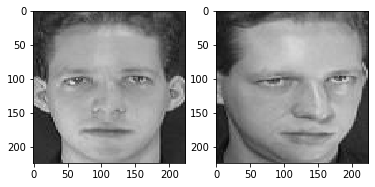

In [188]:
input1 = '../../../att-database-of-faces/s1/1.jpg'
input2 = '../../../att-database-of-faces/s1/10.jpg'

verify_face(input1, input2, True)

(0.4815824031829834, 83.30482, 0)

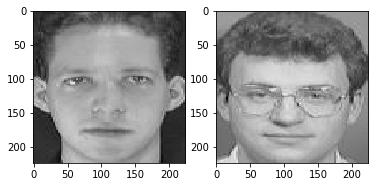

In [189]:
input1 = '../../../att-database-of-faces/s1/1.jpg'
input2 = '../../../att-database-of-faces/s6/4.jpg'

verify_face(input1, input2, True)

#### To test on the AT&T database of faces use the following code to generate test set:

In [200]:
seed(1)

face_pairs = np.empty(shape=(0, 5), dtype=int)

for i in range(1, 41):
    p1 = i
    
    for i in range(1, 4):
        f1 = np.random.randint(1, 11)
        f2 = np.random.randint(1, 11)
    
        while (f1 == f2):
            f2 = np.random.randint(1, 11)
    
        p2 = np.random.randint(1, 41)
        while (p1 == p2):
            p2 = np.random.randint(1, 41)
            
        f3 = np.random.randint(1, 11)

        pair1 = np.array([[p1, f1, p1, f2, 1]])
        pair2 = np.array([[p1, f1, p2, f3, 0]])

        face_pairs = np.append(face_pairs, pair1, axis=0)
        face_pairs = np.append(face_pairs, pair2, axis=0)
    
df_faces = pd.DataFrame(face_pairs, columns=['P1', 'F1', 'P2', 'F2', 'is_same'])

df_faces['P1'] = 's' + df_faces['P1'].astype(str)
df_faces['P2'] = 's' + df_faces['P2'].astype(str)
df_faces['F1'] = df_faces['F1'].astype(str) + '.jpg'
df_faces['F2'] = df_faces['F2'].astype(str) + '.jpg'

df_faces = shuffle(df_faces)

df_faces = df_faces.reset_index(drop=True)

df_faces.head(5)

,P1,F1,P2,F2,is_same
0,s32,9.jpg,s32,1.jpg,1
1,s19,9.jpg,s19,3.jpg,1
2,s14,6.jpg,s28,2.jpg,0
3,s22,10.jpg,s22,6.jpg,1
4,s4,10.jpg,s31,8.jpg,0


#### To test on the LFW dataset use the following code to generate test set:

In [157]:
seed(1)

df1 = pd.read_csv('pairsDevTest1.txt', sep='\t')
df2 = pd.read_csv('pairsDevTest2.txt', sep='\t')

df1['P2'] = df1['P1']
df1['is_same'] = '1'
df1 = df1[['P1', 'F1', 'P2', 'F2', 'is_same']]
df2['is_same'] = '0'

df1 = shuffle(df1)
df2 = shuffle(df2)

def create_filename(inp):
    inp = '0000' + str(inp)
    length = len(inp)
    inp = inp[length - 4:]
    inp = inp + '.jpg'
    return inp

df1['F1'] = df1['F1'].apply(create_filename)
df1['F2'] = df1['F2'].apply(create_filename)
df2['F1'] = df2['F1'].apply(create_filename)
df2['F2'] = df2['F2'].apply(create_filename)

df1['F1'] = df1['P1'].astype(str) + '_' + df1['F1'].astype(str)
df1['F2'] = df1['P2'].astype(str) + '_' + df1['F2'].astype(str)
df2['F1'] = df2['P1'].astype(str) + '_' + df2['F1'].astype(str)
df2['F2'] = df2['P2'].astype(str) + '_' + df2['F2'].astype(str) 

x1_train, x1_test = train_test_split(df1, test_size = 0.1)
x2_train, x2_test = train_test_split(df2, test_size = 0.1)

df_faces = pd.concat([x1_test, x2_test], axis=0)
df_faces = shuffle(df_faces)

df_faces = df_faces.reset_index(drop=True)

df_faces.head(5)

,P1,F1,P2,F2,is_same
0,Mark_Dacey,Mark_Dacey_0001.jpg,Mark_Dacey,Mark_Dacey_0002.jpg,1
1,Lawrence_Roberts,Lawrence_Roberts_0001.jpg,Malik_Mahmud,Malik_Mahmud_0001.jpg,0
2,Gunilla_Backman,Gunilla_Backman_0001.jpg,Ray_Sherman,Ray_Sherman_0001.jpg,0
3,Elinor_Caplan,Elinor_Caplan_0001.jpg,Henning_Scherf,Henning_Scherf_0001.jpg,0
4,Greg_Ostertag,Greg_Ostertag_0001.jpg,Greg_Ostertag,Greg_Ostertag_0002.jpg,1


In [201]:
epsilons = [0.20, 0.30, 0.40, 0.50] #We used cosine similarity
dataset_folder = '../../../att-database-of-faces'

for e in epsilons:
    epsilon = e
    df_faces['cosine_distance'] = 0
    df_faces['euclidean_distance'] = 0
    df_faces['predicted'] = ''
    
    for idx, row in df_faces[df_faces['predicted'] == ''].iterrows():    
        print('epsilon: %2.2f' % epsilon)
        print('processing index: %d started [%d left].' % (idx, len(df_faces) - (idx)))

        img1 = format(dataset_folder + '/%s/%s' % (row['P1'], row['F1']))
        img2 = format(dataset_folder + '/%s/%s' % (row['P2'], row['F2']))

        print(img1)
        print(img2)

        cosine_distance, euclidean_distance, predicted = verify_face(img1, img2, False)

        # print output values
        print('Cosine Distance: %3.3f' % cosine_distance)
        print('Euclidean Distance: %3.3f' % euclidean_distance)

        df_faces.loc[idx, 'cosine_distance'] = cosine_distance
        df_faces.loc[idx, 'euclidean_distance'] = euclidean_distance
        df_faces.loc[idx, 'predicted'] = predicted

        clear_output(wait=True)
    
    df_faces.to_csv(format('results_t%2.2f.csv' % epsilon))

epsilon: 0.50
processing index: 239 started [1 left].
../../../att-database-of-faces/s30/8.jpg
../../../att-database-of-faces/s33/2.jpg
Cosine Distance: 0.378
Euclidean Distance: 91.707
